## 2. Einstieg in CNNs

Im ersten Teil (1. Einstieg in Neuronale Netzwerke) wurden bereits Neuronale Netze mit der Keras-Schnittstelle angelegt. In diesem Teil werden die Vorteile und Besonderheiten von Convolutional-Neuronal-Networks (CNN) behandelt.

In diesem Notbeook werden folgende Themen behandelt
- Einführung CNNs
- Data Augmentation
- Besonderheiten farbige Bilder
- Visualisierung der Zwischenergebnisse

Als Beispieldatensatz wird auch hier der MNIST-Datensatz verwendet.

*Überprüfen Sie zunächst, ob Sie eine Tensorflow-Version > 2.0 verwenden*

In [1]:
# Überprüfen der Installation
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Ausgeben der Version
tf.__version__

'2.1.0'

### a-1) Erstellen eines CNNs

Auch Convolutional Layer lassen sich sehr leicht mit der Keras-API hinzufügen.  

Hierfür muss das Datenformat leicht angepasst werden: Da die **Convolutional-Layer** mit farbigen Bildern (3 Farbkanäle) und mit Grauwertbildern (1 Farbkanal) arbeiten, müssen die Farbkanäle als eigene Dimension eingefügt werden.
Statt der Dimension der ursprünglichen Bilddaten (28,28) wird die Dimension (28,28,1) verwendet.

Bsp: Dimensionumwandlung Graustufen (2,2) zu (2,2,1)
$$ \left[ \begin{matrix} 0.2 & 0 \\ 0.5 & 0.7 \end{matrix} \right]  \rightarrow \left[ \begin{matrix} [0.2] & [0] \\ [0.5] & [0.7] \end{matrix} \right] $$ 
Bsp. (2,2,3) Farbstufenmatrix $$ \left[ \begin{matrix} [0.2, 0.1,0.5] & [0.4,0.8,0.1] \\ [0.2, 0.1,0.7] &  [0.2, 0.1,0.7] \end{matrix} \right] $$

Führen Sie den folgenden Programmcode aus und beantworten Sie dabei folgende Fragen:
* Der Aufruf padding=’same‘ bewirkt, dass die Randpixel der Bilder kopiert werden, die Bilder also zwei Zeilen und zwei Spalten vergrößert werden. Warum ist das notwendig?
* Wie viele Faltungsmatrizen werden in der ersten Convolutional Layer verwendet?

**Hinweis: Das Ausführen des Programms kann mehrere Minuten dauern - Zeit für einen Kaffee oder zum Nachdenken über die Reflexionsfragen**

In [12]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
tf.keras.backend.set_floatx('float64')

# Setzen des Seeds - Zur Reproduktion, da die initalen Gewichte zufällig gesetzt werden
np.random.seed(42)
tf.random.set_seed(32)

# Laden des Datensatzes
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normieren des Datensatzes (Werte zwischen 0-1)
x_train =  x_train / 255.0
x_test  =  x_test / 255.0
print("Dimension x_train:",x_train.shape)

# Umformen der Daten (Menge, Zeilen, Spalten, Channels (1 = Grauwert))
x_train = x_train.reshape(x_train.shape[0], 28, 28 , 1)
x_test =x_test.reshape(x_test.shape[0], 28, 28 , 1)
    
# Hinzufügen der Schichten in Keras
model = tf.keras.models.Sequential([
    # Convolutional Layer + MaxPooling
    tf.keras.layers.Conv2D(32,(5,5), activation='relu', padding="same", input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(6,6),padding="same", strides=(2,2)),
    # Convolutional Layer + MaxPooling
    tf.keras.layers.Conv2D(64,(5,5), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(4,4),padding="same", strides=(2,2)),
    # Übergang Klassifikator
    tf.keras.layers.Flatten(),                        
    tf.keras.layers.Dense(720, use_bias=True,activation='relu'),   
    tf.keras.layers.Dense(10)                         
])

# Anlegen einer Verlustfunktion: Kreuzentropie wegen Kategorien
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Anlegen eines Optimiziers
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Kompilieren des Modells und Auswahl des Optimizers
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])

# Trainieren des Modells
model.fit(x_train, y_train, epochs=2, batch_size=150, validation_data=(x_test,y_test),validation_freq=1)

Dimension x_train: (60000, 28, 28)
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 249s 4ms/sample - loss: 0.3678 - accuracy: 0.9014 - val_loss: 0.0704 - val_accuracy: 0.9780
Epoch 2/2
60000/60000 [==============================] - 247s 4ms/sample - loss: 0.0838 - accuracy: 0.9740 - val_loss: 0.1098 - val_accuracy: 0.9684


**Zusatzaufgabe** Finden Sie heraus, wie viele trainierbare Parameter das Modell besitzt!

In [13]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 720)               2258640   
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

*Das benutzte model()-Objekt stammt aus dem Abschnitt a-1. Bitte führe den Abschnitt vor diesem Teil aus.*

### a-2) Vorhersage von augmentierten Daten

Im vorherigen Aufgabenteil konnte ein FCNN alleine nicht gegen leicht abgeänderte Daten bestehen.
Durch ihren Aufbau sind CNNs gegen bestimmte Veränderungen robuster. Probieren Sie es aus!

*Zur Erinnerung:* In diesem Teil wird das Bildzentrum in die x- und y-Richtung um eine zufällige Zahl im Intervall $[-8, +8]$ verschoben. In der x-Richtung wäre -8 eine maximale Verschiebung um 8 Pixel nach links. Beispielsweise kann die Verschiebung wie folgt aussehen:
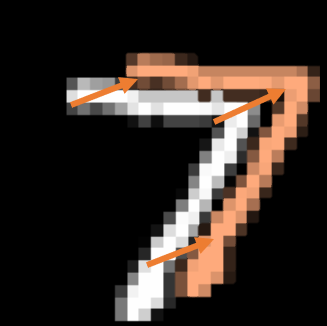

Machen Sie sich zu folgenden Themen Gedanken:
* Was bewirkt das Pooling? Was bedeuten die Optionen in für die angelegte Pooling-Schicht (`max_pooling2d`)?
* Welche Grundidee wurde aus der analytischen Computer Vision durch das Pooling realisiert? Erklären Sie den Effekt bezüglich Skalierung und Translation, den man durch das Pooling erzielt im Hinblick auf die Objekterkennung in den Bildern. 

**Zusatz:** Experimentieren Sie mit den Pooling Kernel. Kann das Erkennen von verschobenen Ziffern noch verbessert werden?

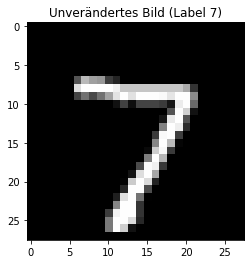

Prognose: 	 7


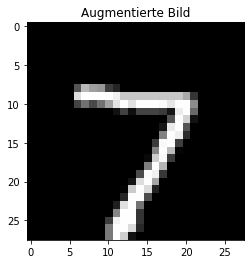

Prognose: 	 7


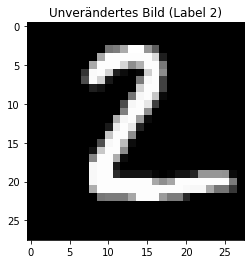

Prognose: 	 2


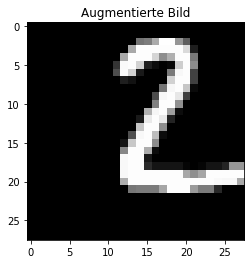

Prognose: 	 2


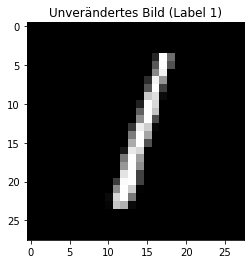

Prognose: 	 1


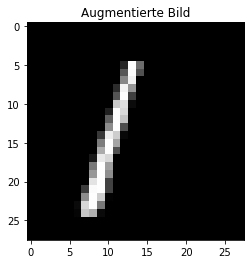

Prognose: 	 1


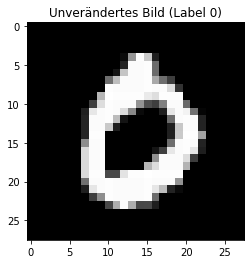

Prognose: 	 0


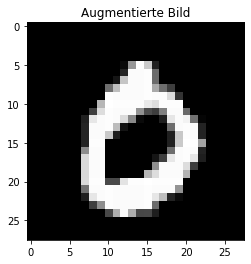

Prognose: 	 0


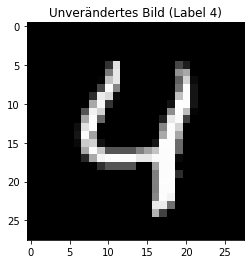

Prognose: 	 4


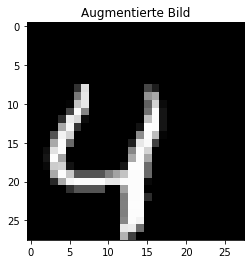

Prognose: 	 9


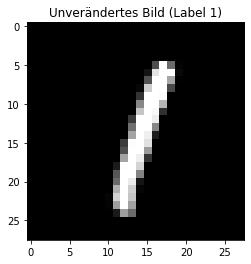

Prognose: 	 1


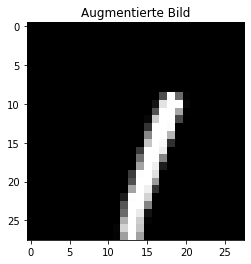

Prognose: 	 1


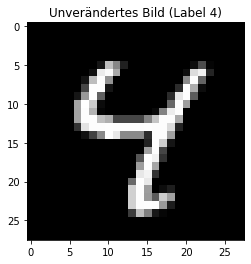

Prognose: 	 4


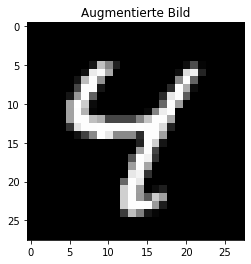

Prognose: 	 4


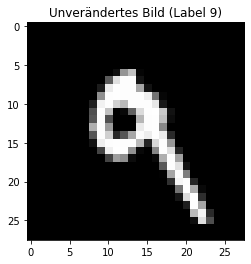

Prognose: 	 9


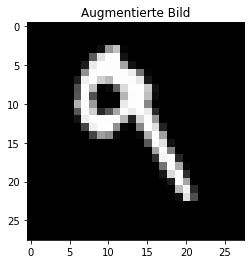

Prognose: 	 1


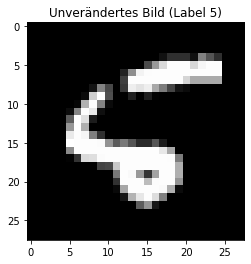

Prognose: 	 5


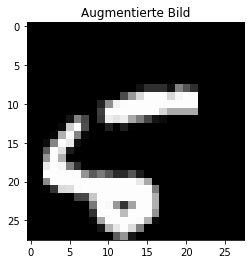

Prognose: 	 5


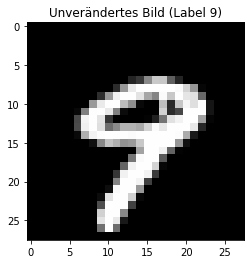

Prognose: 	 9


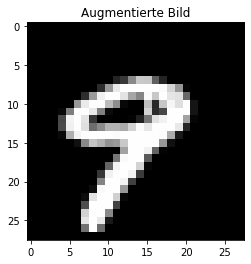

Prognose: 	 9


In [14]:
import matplotlib.pyplot as plt 

# Funktion zum Agumentieren
def augment(image):
    image = np.array(image).reshape((28, 28, 1))
    image = tf.image.resize_with_crop_or_pad(image, 36, 36) # Hinzufügen von 8 Pixeln Rahmen
    image = tf.image.random_crop(image, size=[28, 28, 1])  # Zufälliges Zurückschneiden auf 28 x 28
    return image

for i in range(10):
    # Visualisierung unverändertes Bild
    image = x_test[i]
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title("Unverändertes Bild (Label {})".format(y_test[i]))
    plt.show()
    
    # Prognose unverändertes Bild
    predictions = model(np.array(x_test[i]).reshape(1,28,28,1)).numpy()
    probs = tf.nn.softmax(predictions).numpy()
    print("Prognose: \t", np.argmax(probs[0]))
    
    # Visualisierung verändertes Bild
    aug_image = augment([x_test[i]])
    pixels = np.array(aug_image).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title("Augmentierte Bild")
    plt.show()
    
    # Prognose verändertes Bild
    predictions = model(np.array(pixels).reshape(1,28,28,1)).numpy()
    probs = tf.nn.softmax(predictions).numpy()
    print("Prognose: \t", np.argmax(probs[0]))

### b) Data Augmentation

In diesem Abschnitt lernen Sie weitere Möglichkeiten kennen, die Datenmenge für ihr Netz durch Augmentieren zu Vergößern.
Die aufgeführten Operationen sind für Grauwertbilder geeignet und stellen nur eine Auswahl der Möglichkeiten dar.

Fragen zum Nachdenken
* Welche weiteren Operationen sind bei Grauwert-Bildern möglich?
* Welche weiteren Operationen sind bei Farbbildern möglich?
* Welche Grenzen hat Data Augmentation? Finde ein Beispiel.


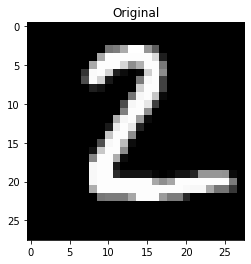

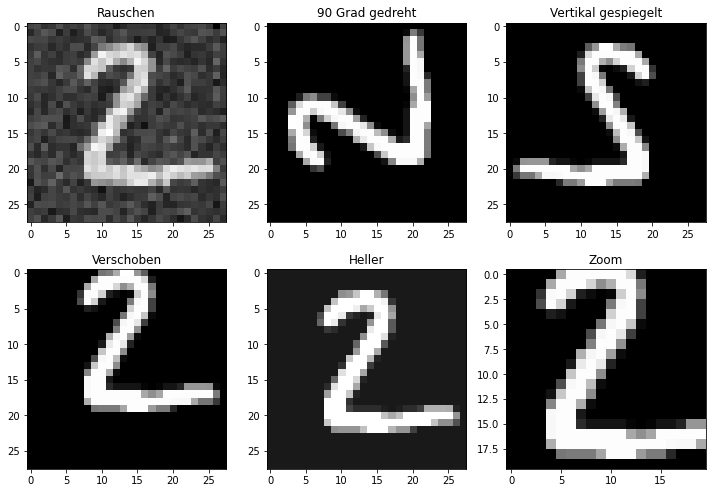

In [15]:
# Auswahl eines Bilder
image = x_test[1]

# Anzeigen des Original Bildes
plt.imshow(np.array(image).reshape((28, 28)), cmap='gray')
plt.title("Original")
plt.show()


# Spiegelungen (falls anwendbar)
flipped = tf.image.flip_left_right(image)
           
# Rotation
rotated = tf.image.rot90(image)

# Translation 
def shift6px(image):
    image = tf.image.resize_with_crop_or_pad(image, 34, 34)  # 6 Pixel Rahmen 
    image = tf.image.random_crop(image, size=[28, 28, 1])    # Zurückschneiden auf 28x28
    return image

# Skalierung
cropped = tf.image.central_crop(image, central_fraction=0.7)

# Verschieben der Bildmitte
shifted = shift6px(image)

# Helligkeit
bright = tf.image.adjust_brightness(image,0.1)

# Gaußsches Rauschen
def gaussian_noise_layer(image):
    noise = tf.keras.backend.random_normal(shape=tf.shape(image), mean=0.0, stddev=0.1) 
    return image + noise
noise = gaussian_noise_layer(image)


# Visualisieren der abgeänderten Bilder
fig, axs = plt.subplots(2, 3,figsize=(10,7))

# Augmentierte Bilder
axs[1,0].imshow(np.array(shifted).reshape((28, 28)), cmap='gray')
axs[1,0].set_title("Verschoben")
axs[1,1].imshow(np.array(bright).reshape((28, 28)), cmap='gray',vmin=0, vmax=1)
axs[1,1].set_title("Heller")
axs[1,2].imshow(np.array(cropped).reshape((20,20)), cmap='gray',vmin=0, vmax=1)
axs[1,2].set_title("Zoom")
axs[0,0].imshow(np.array(noise).reshape((28, 28)), cmap='gray')
axs[0,0].set_title("Rauschen")
axs[0,1].imshow(np.array(rotated).reshape((28, 28)), cmap='gray')
axs[0,1].set_title("90 Grad gedreht")
axs[0,2].imshow(np.array(flipped).reshape((28, 28)), cmap='gray')
axs[0,2].set_title("Vertikal gespiegelt")

plt.tight_layout()
plt.show()

**Hinweis: Das Ausführen des Programms kann eine ganze Weile dauern - Zeit für einen Kaffee oder zum Nachdenken über die Reflexionsfragen**

### Zusatz) Mehrfarbiges Bild

Im folgenden wird der [CIFAR-Datensatz](https://www.cs.toronto.edu/~kriz/cifar.html) analysiert. Dieser Datensatz besteht aus farbigen 32x32 Pixel Bildern mit 10 verschiedenen Motiven wie Flugzeugen, Fröschen und Autos. Auch diese Daten können einfach über Tensorflow in das Notebook geladen werden. Als Alternative können die Daten auch von der Website geladen werden und über den Dateipfad in das Notebook integriert werden.

Folgende Fragen helfen Ihnen beim Verständis:
* Was ist anders im Gegensatz zu dem MNIST-Datensatz?
* Informiere dich, wie die Faltung in den Convolutional Layern bei farbigen Bildern abläuft.
* Welche Dimensionen haben die Schichten? Wie viele Parameter werden hier trainiert?

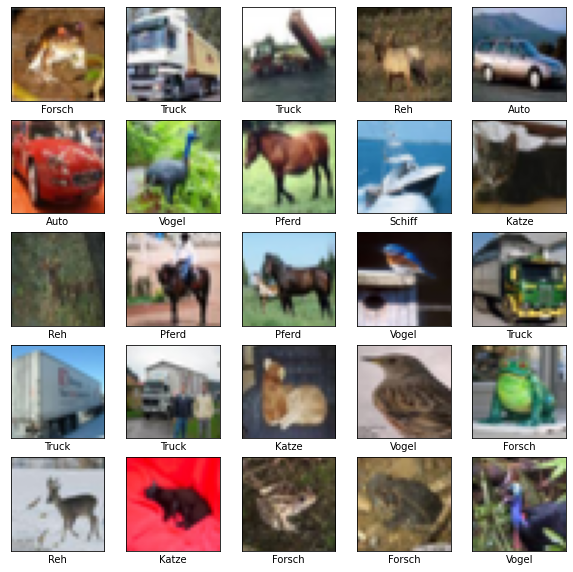

Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 101s 2ms/sample - loss: 1.6850 - accuracy: 0.3786 - val_loss: 1.4139 - val_accuracy: 0.4935
Epoch 2/8
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.3421 - accuracy: 0.5192 - val_loss: 1.2506 - val_accuracy: 0.5509
Epoch 3/8
50000/50000 [==============================] - 100s 2ms/sample - loss: 1.2035 - accuracy: 0.5746 - val_loss: 1.1653 - val_accuracy: 0.5902
Epoch 4/8
50000/50000 [==============================] - 95s 2ms/sample - loss: 1.1077 - accuracy: 0.6117 - val_loss: 1.0823 - val_accuracy: 0.6220
Epoch 5/8
50000/50000 [==============================] - 95s 2ms/sample - loss: 1.0321 - accuracy: 0.6390 - val_loss: 1.0379 - val_accuracy: 0.6359
Epoch 6/8
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.9720 - accuracy: 0.6630 - val_loss: 1.0002 - val_accuracy: 0.6481
Epoch 7/8
50000/50000 [==============================] - 97s

In [16]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Laden der Bilddateb
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalisieren der Bildaten
train_images = train_images / 255.0
test_images =  test_images / 255.0

labels = ['Flugzeug','Auto','Vogel','Katze','Reh','Hund','Forsch','Pferd','Schiff','Truck']

# Visualisieren der ersten 25 Bilder
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[train_labels[i][0]]) # Labels sind eine verschachtelte Array [[1]]
plt.show()

# Alternatives Anlegen eines Modells mit model.add(LAYER)
model_cifar = models.Sequential()
# Convolutional Layers
model_cifar.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cifar.add(layers.MaxPooling2D((2, 2)))
model_cifar.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cifar.add(layers.MaxPooling2D((2, 2)))
model_cifar.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Klassifikator
model_cifar.add(layers.Flatten())
model_cifar.add(layers.Dense(64, activation='relu'))
model_cifar.add(layers.Dense(10))

model_cifar.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_cifar.fit(train_images, train_labels, epochs=8, 
                    validation_data=(test_images, test_labels),batch_size=150,)


### Visualisierung von Filtern der Neuronalen Netzwerke
 
Folgender Code extrahiert die Filter-Gewichte aus der ersten Convolutional-Layer des trainierten CNNs. Diese werden anschließend visualisiert. Schauen Sie sich die Filter genauer an, erkennen Sie gängige Faltungskerne?

[Hier](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/) gibt es mehr zum Thema Filter-Visualisierung.

Dimensionen Gewichte 1. Conv-Layer (3, 3, 3, 32)
Visualisierung der 32 Filter der ersten Schicht:


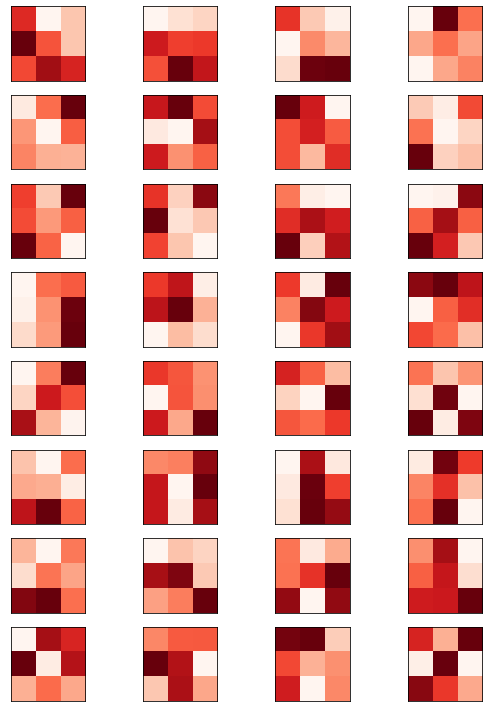

In [20]:
for layer in model_cifar.layers:
    # Ausführung nur für Convolutional Layer
    if 'conv' in layer.name:
        # Speichern der Gewichte 
        filters, biases = layer.get_weights()
        
        # Ausgabe der Dimensionen: 32 Filterkerne
        print("Dimensionen Gewichte 1. Conv-Layer", filters.shape)
        
        # Anlegen eines Subplots
        fig, axs = plt.subplots(8, 4,figsize=(8,10))
        ix = 0
        
        print("Visualisierung der 32 Filter der ersten Schicht:")
        for zeile in range(8):
            for spalte in range(4):
                # Visualisieren eines Filters
                f = filters[:, :, 0, ix].reshape(3,3) # !Auswahl nur einer Farbe 
                axs[zeile, spalte].imshow(f,cmap='Reds')
                axs[zeile, spalte].set_xticks([])
                axs[zeile, spalte].set_yticks([])
                ix = ix + 1
                
        # Ausstieg, da nur eine Schicht visualisiert wird
        break
                
plt.tight_layout()
plt.show()

### Visualisierung von Feature-Maps der Neuronalen Netzwerke

Die Zwischenschritte in CNNs werden auch Feature-Maps genannt und lassen sich ebenfalls visualisieren.
Im folgenden Code wird die Featuremap nach der ersten Schicht (Convolutional Layer und Max-Pooling-Layer) ausgegeben.

In dem Codeteil `outputs=model_fm.layers[1].output`wird festgelegt, nach welcher Schicht die Ausgabe erfolgen soll.
Folglich können Sie auch die Ausgabe nach der 2. oder 3. Convolutional Layer betrachten, in dem Sie die Output-Schicht entsprechend definieren.

Struktur des angelegten Modells
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15_input (InputLayer) [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


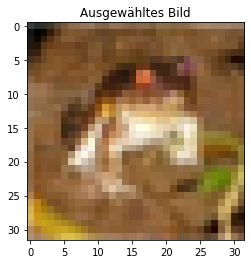

Visualisierung der Feature-Maps der ersten Schicht:


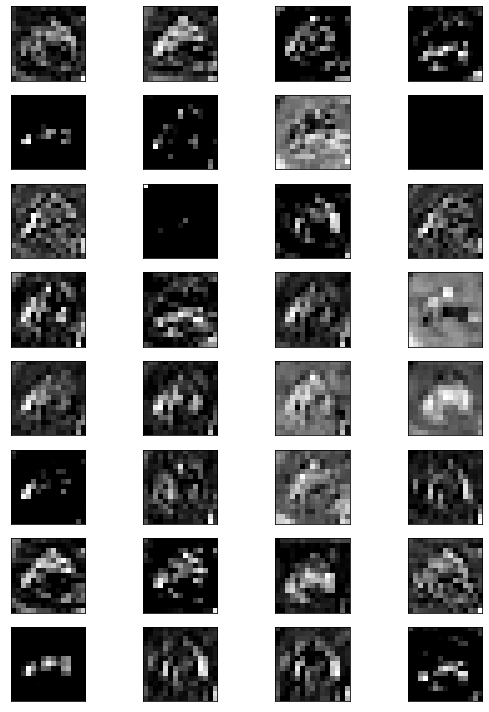

In [18]:
# Laden des Modells
model_fm = model_cifar

# Anpassen des Modells (Output nach erster 2. Schicht (Max-Pooling)
model_fm = tf.keras.models.Model(inputs=model_fm.inputs, outputs=model_fm.layers[1].output)
print("Struktur des angelegten Modells")
model_fm.summary()

# Auswahl eines Bilders
img = train_images[0]

# Anzeigen des Bildes
plt.imshow(img.reshape(32,32,3))
plt.title("Ausgewähltes Bild")
plt.show()

feature_maps = model_fm.predict(img.reshape(1,32,32,3))
feature_maps.shape

# Anlegen eines Subplots
fig, axs = plt.subplots(8, 4,figsize=(8,10))
ix = 0

print("Visualisierung der Feature-Maps der ersten Schicht:")
for zeile in range(8):
    for spalte in range(4):
        # Visualisieren einer Feature-Map
        f = feature_maps[0,:,:, ix].reshape(15,15)
        axs[zeile, spalte].imshow(f,cmap='gray')
        axs[zeile, spalte].set_xticks([])
        axs[zeile, spalte].set_yticks([])
        ix = ix + 1
        
plt.tight_layout()
plt.show()

### Zusatzaufgabe) Erstellen eines eignen CNNs

Jetzt sind Sie an der Reihe! Erstellen Sie ihr eignes Netz mit Faltungsschichten. Verwende dafür den MNIST-Fashion-Datensatz.

**Aufgaben**
* Normieren Sie die Pixelwert auf den Bereich (0-255)
* Wandelen Sie die Dimension der Daten um (28,28,1)
* Entwerfen Sie ein 5-Schichten-Modell: 
  - Die *Input-Layer* muss das 2D-Bild in einen 1D-Vektor überführen. 
  - Eine *Convolutional-Layer* mit MaxPooling
  - Der *Flatten-Layer* bildet den Übergang zum Klassifikator
  - Die *Hidden-Layer* kann beliebig (aber sinnvoll!) gewählt werden.
  - Die *Output-Layer* muss in den Dimensionen mit der Zielvariable y übereinstimmen.
* Kompilieren Sie das Modell mit einem Optimizier, einer Verlustfunktion (passend zu den One-Hot-Encoding der y-Werte!) und der Metrik 'accuracy'
* Trainieren Sie das Modell

**Tipp** Da das Modell in einigen Fällen nicht konvergiert, können Sie folgende Hilfestellungen veruschen
- Optimizier `tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)`
- Kernel-Inializier `kernel_initializer='he_uniform'`

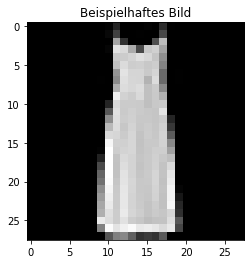

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 16s 275us/sample - loss: 2.2880 - accuracy: 0.1836
Epoch 2/10
60000/60000 [==============================] - 18s 298us/sample - loss: 2.1798 - accuracy: 0.2588
Epoch 3/10
60000/60000 [==============================] - 18s 297us/sample - loss: 1.5923 - accuracy: 0.4640
Epoch 4/10
60000/60000 [==============================] - 19s 314us/sample - loss: 1.0660 - accuracy: 0.6294
Epoch 5/10
60000/60000 [==============================] - 18s 306us/sample - loss: 0.8543 - accuracy: 0.6926-
Epoch 6/10
60000/60000 [==============================] - 17s 279us/sample - loss: 0.7554 - accuracy: 0.7251
Epoch 7/10
60000/60000 [==============================] - 17s 283us/sample - loss: 0.6995 - accuracy: 0.7416
Epoch 8/10
60000/60000 [==============================] - 19s 322us/sample - loss: 0.6612 - accuracy: 0.7535
Epoch 9/10
60000/60000 [==============================] - 19s 324us/sample - loss: 0.6359 - accuracy: 0.

In [19]:
import tensorflow as tf
from numpy.random import seed
tf.keras.backend.set_floatx('float32')

# Setzen des Seeds (zufällige Initalisierung der Gewichte)
seed(56)
tf.random.set_seed(56)

# Laden der Daten
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# OneHot-Encoding für die Zielvariablen
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Anlegen der Labels
labels = ["T-Shirt/Top","Hose","Pullover","Kleid","Jacke","Sandalen", "Shirt","Sneaker","Handtasche","Stiefel"]

# Visualisieren des ersten Bildes
image = 13  # Ändern zum Anzeigen eines beliebigen Bildes
pixels = x_test[image].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.title("Beispielhaftes Bild")
plt.show()

##### Ergänze den Code unter dieser Zeile ###############

# Normieren des Datensatzes (Werte zwischen 0-1)
x_train =  x_train / 255.0
x_test  =  x_test / 255.0
x_train =  x_train / 255.0
x_test  =  x_test / 255.0

# Umformen der Daten (Menge, Zeilen, Spalten, Channels (1 = Grauwert))
x_train = x_train.reshape(x_train.shape[0], 28, 28 , 1)
x_test =x_test.reshape(x_test.shape[0], 28, 28 , 1)
    
# Hinzufügen der Schichten in Keras
model_fashion = tf.keras.models.Sequential([
    # Convolutional Layer + MaxPooling
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # Übergang Klassifikator
    tf.keras.layers.Flatten(),                        
    tf.keras.layers.Dense(100, activation='relu',kernel_initializer='he_uniform'),  
    tf.keras.layers.Dense(10, activation='softmax')                            # Output-Layer für die 10 Kleidungsstücke
])

# Anlegen eines Optimiziers
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)

# Kompilieren des Modells und Auswahl des Optimizers
model_fashion.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# Trainieren des Modells
model_fashion.fit(x_train, y_train, epochs=10, batch_size=100) #validation_data=(x_test,y_test),validation_freq=1)